In [31]:
suppressMessages(library(survminer))
suppressMessages(library(survival))
suppressMessages(library(forestplot))
suppressMessages(library(ggsci))
suppressMessages(library(dplyr))
library(adjustedCurves)

## 1. Load Dataset
---

In [2]:
data.df <- read.table("data/processed/AL_with_ccp_03.tsv", sep="\t", header=T, row.names='Code.ID')

# Rename columns
column_mapping <- c("LC.Isotype"="Kappa_or_lambda_PCD", 
                    "BU.Cardiac.Stage"="BU__BNP_based__cardiac_staging",
                    "BMPC.%"="Bone_marrow_plasma_cells____"
                   )

data.df <- data.df %>% rename(!!!column_mapping)

# Filter for time from admission >=0
data.df <- data.df[data.df$time_from_admission>=0,]

# Collapse Race
data.df <- data.df %>%
   mutate(Race = ifelse(Race %in% c('American_Indian_Alaska_Native','Multiracial','Native_Hawaiian_Pacific', 'Unknown/other'), 'Other', Race))

# Fix NULL values
data.df <- data.df %>% mutate(BU.Cardiac.Stage = ifelse(BU.Cardiac.Stage=="", NA, BU.Cardiac.Stage))
data.df <- data.df %>% mutate(Primary_organ = ifelse(Primary_organ=="", NA, Primary_organ))
data.df <- data.df %>% mutate(LC.Isotype = ifelse(LC.Isotype=="", NA, LC.Isotype))

# assign cluster to var
data.df$cluster <- factor(data.df$cluster, levels=c("Low","Intermediate","High"))
data.df <- data.df[complete.cases(data.df[,"cluster"]),]
data.df$BU.Cardiac.Stage <- as.factor(data.df$BU.Cardiac.Stage)

### 2. Survival Curves
---

In [27]:
plotSurv <- function(fit, data.df, legend.title, legend.labs, ...){
    p <- ggsurvplot(
        fit,                    
        data = data.df,
        risk.table = TRUE,
        pval = TRUE,
        conf.int = TRUE,
        xlab = "Time (Yr)",
        risk.table.y.text.col = T,
        risk.table.y.text = F,
        legend.title = legend.title,
        legend.labs = legend.labs,
        ...
    )
    
    return(p)
}

In [30]:
pdf("figures/cluster_km_curve.pdf", h=8, w=6)
fit <- survfit(Surv(time, status) ~ cluster, data=data.df)
plotSurv(fit, data.df, "BU Staging", NULL, palette=c("#62b67d","#69a9c8","#ca4a29"), 
         surv.median.line="v", xlim = c(0, 12), break.time.by=2)
dev.off()

pdf 
  2

## 3. Cox Regressions
---

In [60]:
cox_model <- coxph(Surv(time_from_admission, status) ~ LC.Isotype + Age + Sex + 
                   Race + Troponin + eGFR  + BU.Cardiac.Stage, data=data.df)
obj <- ggforest(cox_model)
ggsave("figures/AL_dataset_coxph_forest.pdf", plot = obj, width = 8, height = 10)

cox_model <- coxph(Surv(time_from_admission, status) ~ LC.Isotype + Age + Sex + 
                   Race + Troponin + eGFR  + BU.Cardiac.Stage + cluster, data=data.df)
obj <- ggforest(cox_model)
ggsave("figures/AL_dataset_coxph_clust_forest.pdf", plot = obj, width = 7, height = 8)

cox_model <- coxph(Surv(time_from_admission, status) ~ LC.Isotype + Age + Sex + 
                   Race + Troponin + eGFR + BU.Cardiac.Stage + cluster4, data=data.df)
obj <- ggforest(cox_model)
ggsave("figures/AL_dataset_coxph_clust4_forest.pdf", plot = obj, width = 7, height = 8)

Warning message in .get_data(model, data = data):
“The `data` argument is not provided. Data will be extracted from model fit.”
Warning message in .get_data(model, data = data):
“The `data` argument is not provided. Data will be extracted from model fit.”
Warning message in .get_data(model, data = data):
“The `data` argument is not provided. Data will be extracted from model fit.”


In [53]:
# Surv Object
time <- data.df$time_from_admission
status <- data.df$status
surv.obj <- Surv(time,status)

mod.1 <- coxph(Surv(time_from_admission, status) ~ LC.Isotype + Age + Sex + Race + Troponin + eGFR + Primary_organ + BU.Cardiac.Stage, data = data.df)
mod.2 <- update(mod.1, . ~ . + cluster)
mod.3 <- coxph(Surv(time_from_admission, status) ~ LC.Isotype + Age + Sex + Race + Troponin + eGFR + Primary_organ + cluster, data = data.df)

mod.clust.1 <- coxph(Surv(time_from_admission, status) ~ BU.Cardiac.Stage, data = data.df)
mod.clust.2 <- coxph(Surv(time_from_admission, status) ~ BU.Cardiac.Stage + cluster, data = data.df)
mod.clust.3 <- coxph(Surv(time_from_admission, status) ~ cluster, data = data.df)

In [31]:
mod.1$concordance

concordant   discordant       tied.x       tied.y      tied.xy  concordance 
1.805490e+05 6.787800e+04 0.000000e+00 7.900000e+01 0.000000e+00 7.267688e-01 
         std 
1.180510e-02

In [32]:
mod.2$concordance

concordant  discordant      tied.x      tied.y     tied.xy concordance 
1.81581e+05 6.68460e+04 0.00000e+00 7.90000e+01 0.00000e+00 7.30923e-01 
        std 
1.15854e-02

In [33]:
mod.3$concordance

concordant   discordant       tied.x       tied.y      tied.xy  concordance 
1.768620e+05 7.268900e+04 0.000000e+00 7.900000e+01 0.000000e+00 7.087209e-01 
         std 
1.230158e-02

In [54]:
mod.clust.1$concordance

concordant   discordant       tied.x       tied.y      tied.xy  concordance 
1.609890e+05 4.909600e+04 7.825000e+04 6.000000e+01 3.300000e+01 6.940330e-01 
         std 
1.140872e-02

In [55]:
mod.clust.2$concordance

concordant   discordant       tied.x       tied.y      tied.xy  concordance 
1.876980e+05 6.852300e+04 3.211400e+04 7.500000e+01 1.800000e+01 7.066607e-01 
         std 
1.155338e-02

In [56]:
mod.clust.3$concordance

concordant   discordant       tied.x       tied.y      tied.xy  concordance 
6.316940e+05 3.081640e+05 4.778790e+05 3.840000e+02 2.560000e+02 6.141009e-01 
         std 
7.344282e-03

## 4. Adjusted Survival Curves
---

In [40]:
vars.in.model <- c("LC.Isotype","Age","Sex","Race","Primary_organ","Era","cluster","status","time_from_admission")

to.keep <- rownames(na.omit(data.df[,vars.in.model]))
fit <- coxph(Surv(time, status) ~ LC.Isotype + Age + Sex + Race + Primary_organ + Era + cluster, data = data.df[to.keep,], x=TRUE)

# Adjusted survival curve without bootstrap
adjsurv <- adjustedsurv(data=data.df[to.keep,],
                        variable="cluster",
                        ev_time="time_from_admission",
                        event="status",
                        method="direct",
                        outcome_model=fit,
                        conf_int=TRUE,
                        n_cores=8,
                        n_boot=1000,
                        bootstrap=TRUE
                       )

Loading required namespace: doParallel



Warning message:
“Removed 108 rows containing missing values (`geom_step()`).”


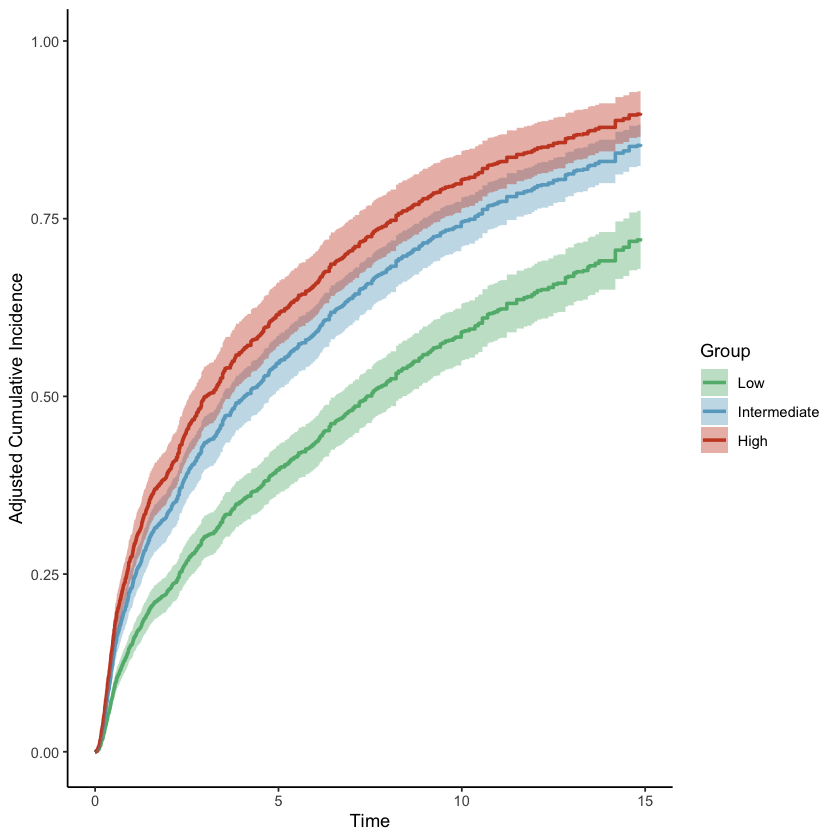

In [41]:
plot(adjsurv, conf_int=TRUE, custom_colors=c("#62b67d","#69a9c8","#ca4a29"), cif=T) + xlim(0,15)


In [ ]:
adj_test <- adjusted_curve_test(adjsurv, from=0, to=15)
summary(adj_test)

In [56]:
pdf("figures/adjusted_surv_clust.pdf")
plot(adjsurv, conf_int=TRUE, custom_colors=c("#62b67d","#69a9c8","#ca4a29"), cif=F)
dev.off()

pdf 
  2

In [ ]:
# Bootstrap
adjsurv.bootstrap <- adjustedsurv(data=data.df[to.keep,],
                        variable="cluster",
                        ev_time="time",
                        event="status",
                        method="direct",
                        outcome_model=fit,
                        conf_int=TRUE,
                        n_cores=8,
                        n_boot=500,
                        bootstrap=TRUE
                       )


adj_test <- adjusted_curve_test(adjsurv.bootstrap, from=0, to=15)
summary(adj_test)

In [ ]:
#pdf("figures/adjusted_surv_clust.pdf")
plot(adjsurv, conf_int=TRUE, custom_colors=c("#62b67d","#69a9c8","#ca4a29"), cif=T)
#dev.off()

In [65]:
adjusted_curve_diff(adjsurv.bootstrap, times=c(1,2,5,10,15), group_1="Low", group_2="Intermediate", conf_int=TRUE)

time,diff,se,ci_lower,ci_upper,p_value
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.06097862,0.02144340,0.01895032,0.1030069,0.0044592924
2,0.08557592,0.02759565,0.03148945,0.1396624,0.0019282530
5,0.12905744,0.03744817,0.05566037,0.2024545,0.0005683302
10,0.14309976,0.04214673,0.06049368,0.2257058,0.0006855965
15,0.11458743,0.04822987,0.02005862,0.2091162,0.0175080999


In [66]:
adjusted_curve_diff(adjsurv.bootstrap, times=c(1,2,5,10,15), group_1="Intermediate", group_2="High", conf_int=TRUE)

time,diff,se,ci_lower,ci_upper,p_value
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.04401550,0.02664368,-0.008205155,0.09623615,0.09853349
2,0.05899906,0.03303923,-0.005756646,0.12375477,0.07414342
5,0.07877507,0.04161561,-0.002790025,0.16034016,0.05836834
10,0.07294866,0.04117240,-0.007747761,0.15364509,0.07643017
15,0.04735756,0.03857799,-0.028253910,0.12296902,0.21960477


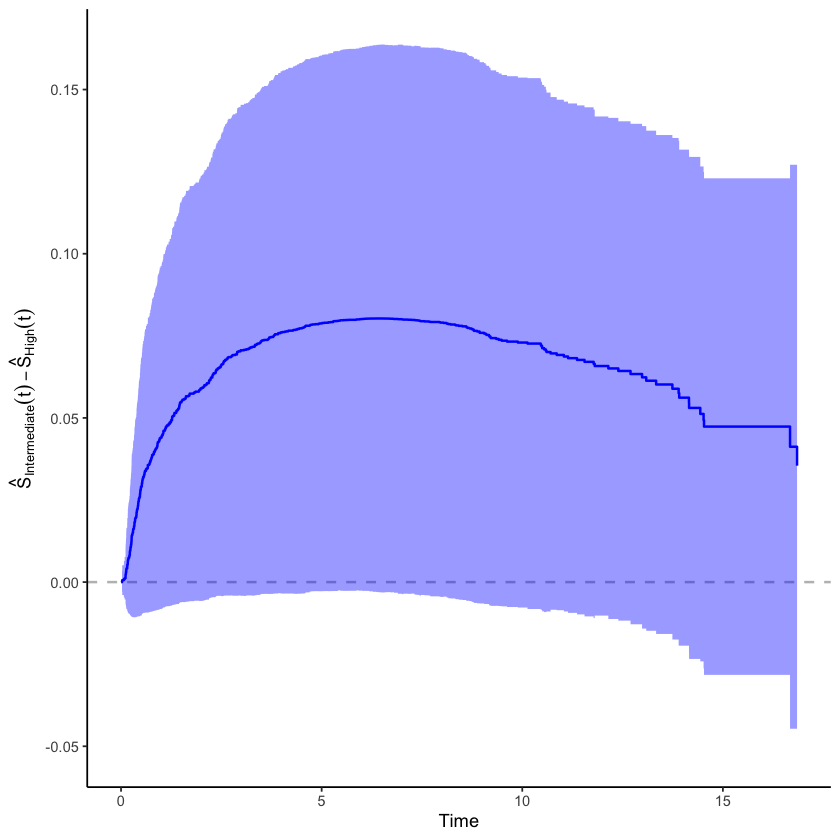

In [67]:
plot_curve_diff(adjsurv, group_1="Intermediate", group_2="High", conf_int=TRUE, color="blue")

Warning message in .get_data(model, data = data):
“The `data` argument is not provided. Data will be extracted from model fit.”


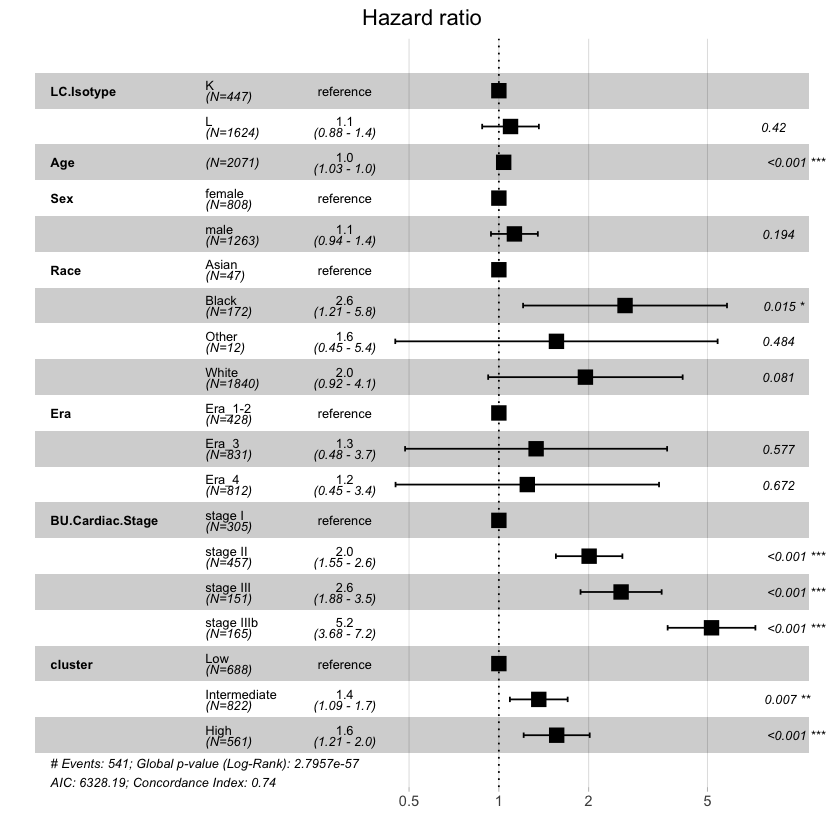

In [32]:
cox_model <- coxph(Surv(time, status) ~ LC.Isotype + Age + Sex + 
                   Race + Era + BU.Cardiac.Stage + cluster, data=data.df)
ggforest(cox_model)

Warning message:
“Cannot draw confidence intervals. Either set 'conf_int=TRUE' in adjustedsurv() call or use bootstrap estimates.”


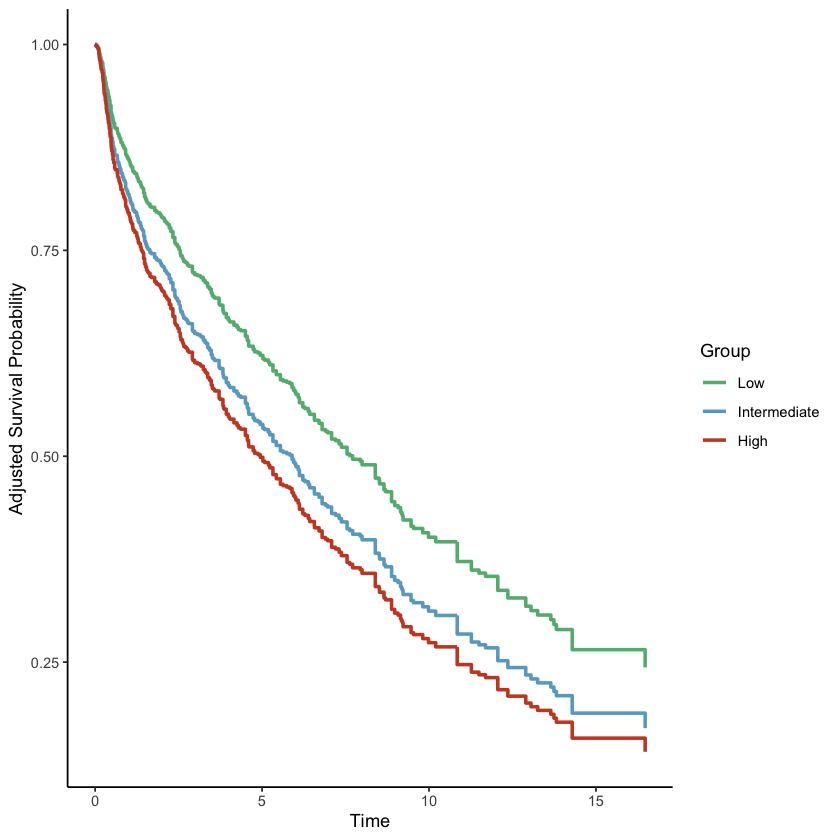

In [38]:
vars.in.model <- c("LC.Isotype","Age","Sex","Race", "Era", "BU.Cardiac.Stage", "cluster","status","time")

to.keep <- rownames(na.omit(data.df[,vars.in.model]))
fit <- coxph(Surv(time, status) ~ LC.Isotype + Age + Sex + Race + Era + BU.Cardiac.Stage + cluster, data = data.df[to.keep,], x=TRUE)

# Adjusted survival curve without bootstrap
adjsurv <- adjustedsurv(data=data.df[to.keep,],
                        variable="cluster",
                        ev_time="time_from_admission",
                        event="status",
                        method="direct",
                        outcome_model=fit,
                        conf_int=F,
                        n_cores=8,
                       )


#pdf("figures/adjusted_surv_clust.pdf")
plot(adjsurv, conf_int=TRUE, custom_colors=c("#62b67d","#69a9c8","#ca4a29"))
#dev.off()

In [51]:
fit <- coxph(Surv(time_from_admission, status) ~ LC.Isotype + Age + Sex + Race +
             Primary_organ + Troponin + eGFR + cluster, data = data.df[to.keep,], x=TRUE)

In [52]:
# Adjusted survival curve without bootstrap
adjsurv <- adjustedsurv(data=data.df[to.keep,],
                        variable="cluster",
                        ev_time="time_from_admission",
                        event="status",
                        method="direct",
                        outcome_model=fit,
                        conf_int=TRUE,
                        cif=TRUE,
                        n_cores=8,
                       )

pdf("figures/adjusted_surv_clust.pdf")
plot(adjsurv, conf_int=TRUE, custom_colors=c("#62b67d","#69a9c8","#ca4a29"))
dev.off()

pdf 
  2

In [39]:
plot.adjustedSurv

ERROR: Error in eval(expr, envir, enclos): object 'plot.adjustedSurv' not found


In [41]:
fit <- coxph(Surv(time_from_admission, status) ~ BU.Cardiac.Stage + cluster, data = data.df[to.keep,], x=TRUE)

Warning message:
“Cannot draw confidence intervals. Either set 'conf_int=TRUE' in adjustedsurv() call or use bootstrap estimates.”


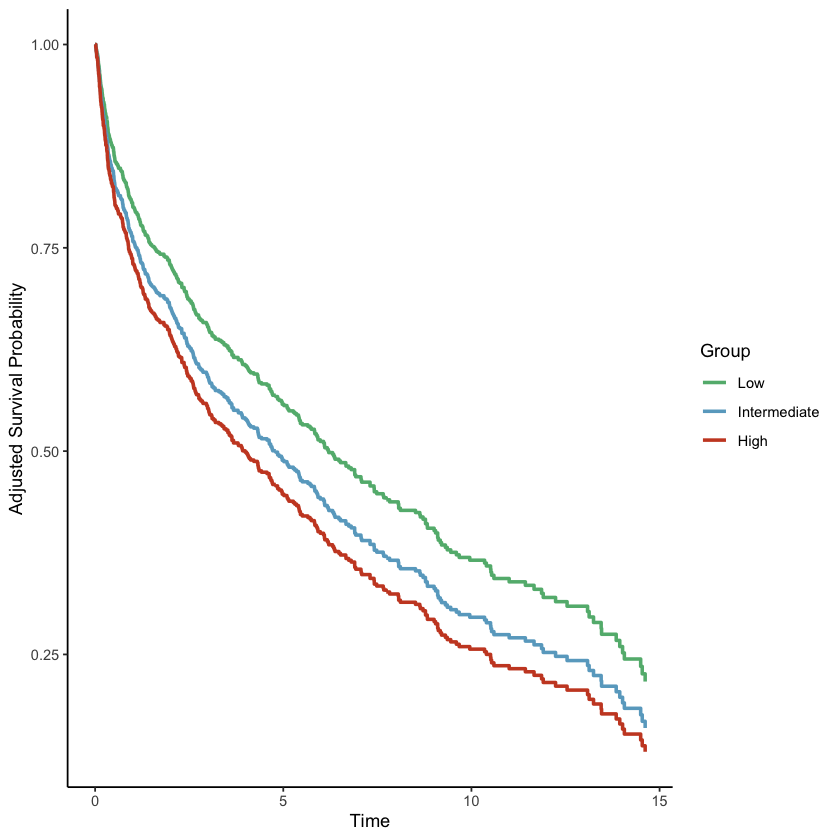

In [43]:
# Adjusted survival curve without bootstrap
adjsurv <- adjustedsurv(data=data.df[to.keep,],
                        variable="cluster",
                        ev_time="time_from_admission",
                        event="status",
                        method="direct",
                        outcome_model=fit,
                        conf_int=F,
                        #cif=TRUE,
                        n_cores=8,
                       )

#pdf("figures/adjusted_surv_clust.pdf")
plot(adjsurv, conf_int=TRUE, custom_colors=c("#62b67d","#69a9c8","#ca4a29"))
#dev.off()

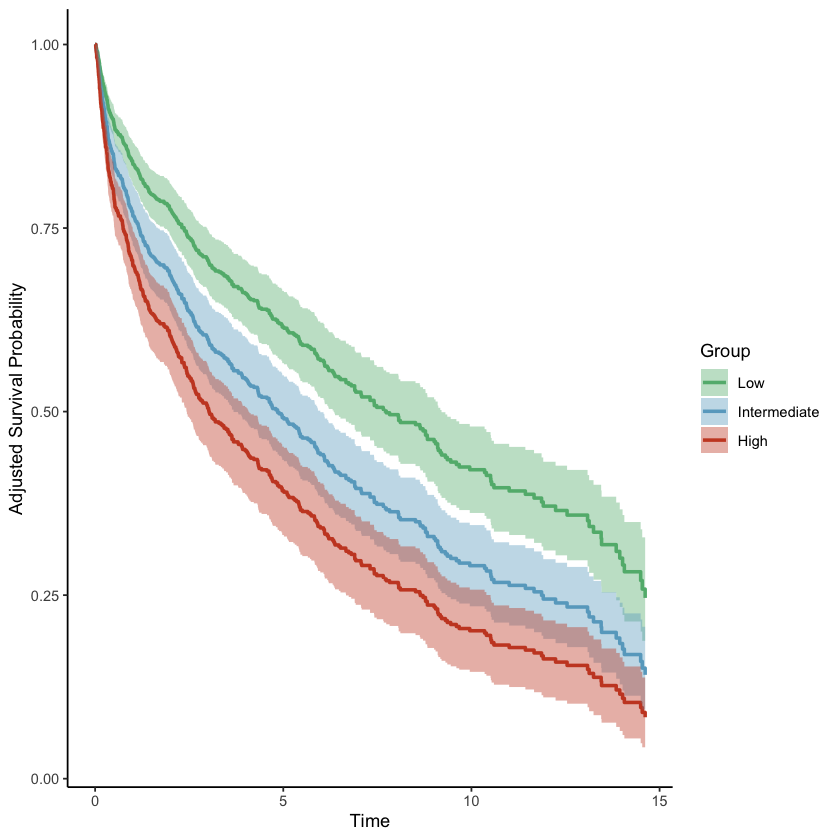

In [33]:
plot(adjsurv, conf_int=TRUE, custom_colors=c("#62b67d","#69a9c8","#ca4a29"))

Warning message in .get_data(model, data = data):
“The `data` argument is not provided. Data will be extracted from model fit.”


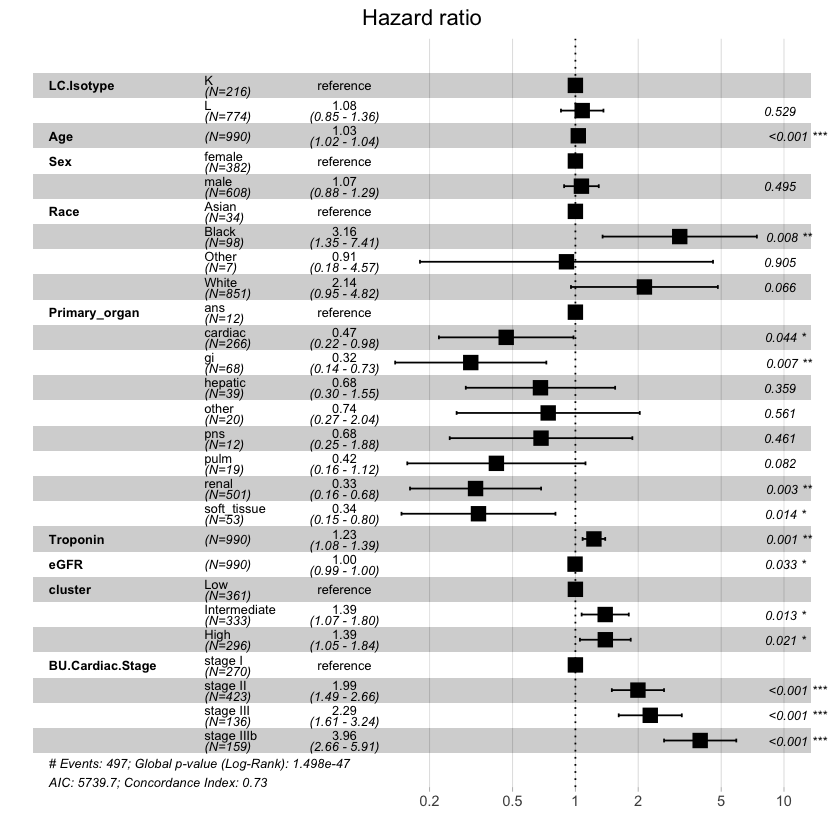

In [12]:
pdf("figures/adjusted_surv_clust_bu.pdf")
ggforest(fit)


In [155]:
# Adjusted survival curve without bootstrap
adjsurv <- adjustedsurv(data=data.df[to.keep,],
                        variable="cluster",
                        ev_time="time_from_admission",
                        event="status",
                        method="direct",
                        outcome_model=fit,
                        conf_int=TRUE,
                        n_cores=8,
                       )

pdf("figures/adjusted_surv_clust.pdf")
plot(adjsurv, conf_int=TRUE, custom_colors=c("#62b67d","#69a9c8","#ca4a29"))
dev.off()

pdf 
  2

In [ ]:
times =custom_times
cif=True

Loading required namespace: doParallel



------------------------------------------------------------------
   Test of the Difference between two adjusted Survival Curves
------------------------------------------------------------------

Using the interval: 0 to 150 

                          ABC ABC SE 95% CI (lower) 95% CI (upper) P-Value
Low vs. Intermediate  17.1406 5.8078         6.5413        29.6360    0.00
Low vs. High          30.2881 4.4528        19.5406        35.6767    0.00
Intermediate vs. High 13.1474 5.0916         2.2466        20.5027    0.01
                      N Boot
Low vs. Intermediate     100
Low vs. High             100
Intermediate vs. High    100
------------------------------------------------------------------


## 5. ESKD Logistic Regression
---

In [18]:
eskd.df <- read.table("data/processed/treatment_eskd.tsv", sep="\t", header=T, row.names="Code.ID")
data.df$eskd <- eskd.df[rownames(data.df),"treatment_eskd"]

In [22]:
log.mod <- glm(eskd ~ LC.Isotype + Age + Sex + Race + Troponin + eGFR +
             Primary_organ + Era + BU.Cardiac.Stage + cluster , family=binomial(link="logit"), data=data.df)

In [23]:
summary(log.mod)


Call:
glm(formula = eskd ~ LC.Isotype + Age + Sex + Race + Troponin + 
    eGFR + Primary_organ + Era + BU.Cardiac.Stage + cluster, 
    family = binomial(link = "logit"), data = data.df)

Coefficients:
                             Estimate Std. Error z value Pr(>|z|)    
(Intercept)                -1.578e+01  3.865e+03  -0.004   0.9967    
LC.IsotypeL                -1.115e-01  2.476e-01  -0.450   0.6524    
Age                        -3.598e-02  1.103e-02  -3.263   0.0011 ** 
Sexmale                     1.561e-01  2.203e-01   0.708   0.4787    
RaceBlack                  -4.940e-01  7.340e-01  -0.673   0.5009    
RaceOther                  -1.142e+00  1.530e+00  -0.746   0.4555    
RaceWhite                  -1.052e-01  6.551e-01  -0.161   0.8724    
Troponin                   -2.636e-01  4.748e-01  -0.555   0.5787    
eGFR                       -3.598e-02  3.964e-03  -9.075  < 2e-16 ***
Primary_organcardiac       -6.853e-02  1.175e+00  -0.058   0.9535    
Primary_organgi           

In [25]:
log.mod <- glm(eskd ~ LC.Isotype + Age + Race + Sex + Troponin + Primary_organ + cluster*eGFR + 
               cluster*X24_hr_UTP + cluster*Albumin, family=binomial(link="logit"), data=data.df)

summary(log.mod)


Call:
glm(formula = eskd ~ LC.Isotype + Age + Race + Sex + Troponin + 
    Primary_organ + cluster * eGFR + cluster * X24_hr_UTP + cluster * 
    Albumin, family = binomial(link = "logit"), data = data.df)

Coefficients:
                                 Estimate Std. Error z value Pr(>|z|)    
(Intercept)                     5.951e+00  2.646e+00   2.249   0.0245 *  
LC.IsotypeL                    -2.000e-01  2.956e-01  -0.677   0.4987    
Age                            -2.969e-02  1.271e-02  -2.336   0.0195 *  
RaceBlack                      -1.119e-01  8.218e-01  -0.136   0.8917    
RaceOther                      -5.150e-01  1.500e+00  -0.343   0.7313    
RaceWhite                       1.521e-01  7.333e-01   0.207   0.8357    
Sexmale                         1.313e-01  2.491e-01   0.527   0.5980    
Troponin                        6.976e-02  3.567e-01   0.196   0.8449    
Primary_organcardiac            2.031e-03  1.189e+00   0.002   0.9986    
Primary_organgi                 8.914e